<font size="6"><b>Model Library</b></font>

# Libraries

As always the first step is to import all the necessary libraries and if times permits it, I will drop a few lines explaining what each one of them does.

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
color = sns.color_palette()

import os
import cv2
from glob import glob
from skimage.io import imread
from skimage.transform import resize

import datetime
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , SeparableConv2D, MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau 
from keras import backend as K

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

original_start = datetime.datetime.now()
start = datetime.datetime.now()

# Data gathering

As previously mentioned, the dataset was downloaded from Kaggle (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) where it was already divided into three initial sets in separate folders (test, train, and val) each containing sub-folders (NORMAL and PNEUMONIA) where the X-ray images have been already labeled.  

According to the description of the dataset in Kaggle, there are 5856 images in this dataset, but I have no information of how many x-rays have been allocated per set/folder, therefore, the first thing to do is to set up the location of the main directory so that the X-rays can be accessed, followed by a quick review of it's content, meaning how many X-rays have been allocated in each sub-set/folder

In [30]:
main_directory = os.listdir('../chest_xray/')
print(main_directory)

['.DS_Store', 'test', 'train', '.ipynb_checkpoints', 'val']


The printout shows a couple of hidden files (.DS_Store and .ipynb_checkpoints) plus three directories which are the ones of our interest corresponding to the three initial subsets. 

Figure_2 is a snapshot taken from a mac illustrating the presence of the two directories inside each of the main subsets, which correspond to the labeling or classification already done to these X-ray images.

![Figure_2](img/Figure_2.png)

Figure_1. Data configuration established by the contributor (Kaggle) with each of the three main folders containing the X-rays already classified into NORMAL and PNEUMONIA

Now that we have access to the directory where the data is located lets define the paths for each of the datasets:

In [31]:
# Directory paths:

data_dir = "../chest_xray/"
train_dir = os.path.join(data_dir, "train/")
test_dir = os.path.join(data_dir, "test/")
val_dir = os.path.join(data_dir, "val/")

Now I will define direct paths for each of the NORMAL and PNEUMONIA folders within each of the three main folders (test, train and val):

In [32]:
# train folder data

os.listdir(train_dir)
train_normal = train_dir + 'NORMAL/'
train_pneumo = train_dir + 'PNEUMONIA/'

# test folder data

os.listdir(test_dir)
test_normal = test_dir + 'NORMAL/'
test_pneumo = test_dir + 'PNEUMONIA/'

# val folder data

os.listdir(val_dir)
val_normal = val_dir + 'NORMAL/'
val_pneumo = val_dir + 'PNEUMONIA/'

With this done I am ready to start familiarizing myself with the data and as I mentioned above, the first thing to do is to find out how many X-rays have been allocated to each of these subsets to then make a decision if I will keep these split or if I will have to modify it.

In order to do this, I will define a function that will allow me to see the number of files within each folder. This function will have 2 variables or entries that will be:

1. xray_normal: should receive only the normal folder locations of each of the 3 sub-sets

2. xray_pneumo: should receive only the pneumonia folder locations of each of the 3 sub-sets

In [33]:
# Function that will access all the subset folders (train, test and val) to address the numbers of X-rays per folder

def number_of_xrays(xray_normal, xray_pneumo):  
    
# X-Rays classified as 'NORMAL' or equal to 'No Pneumonia'

    print('Number of X-rays classified as NORMAL:', len(os.listdir(xray_normal))) # Number of x-rays classified as 'NORMAL'

# X-rays classified as 'PNEUMONIA' meaning that the patient has pneumonia

    print('Number of X-rays classified as PNEUMONIA:', len(os.listdir(xray_pneumo))) # Number of x-rays classified as 'PNEUMONIA'

# Total number of X-rays

    print('Total number of Train X-rays:', len(os.listdir(xray_normal)) + len(os.listdir(xray_pneumo)))

Now, lets test the function using each of the 3 datasets and see if they add up to the total of 5856 x-rays mentioned on Kaggle (data source):

In [34]:
print('Train set X-rays content:')
print('------------------------')
number_of_xrays(train_normal, train_pneumo)

Train set X-rays content:
------------------------
Number of X-rays classified as NORMAL: 1341
Number of X-rays classified as PNEUMONIA: 3875
Total number of Train X-rays: 5216


In [35]:
print('Test set X-rays content:')
print('------------------------')
number_of_xrays(test_normal, test_pneumo)

Test set X-rays content:
------------------------
Number of X-rays classified as NORMAL: 184
Number of X-rays classified as PNEUMONIA: 341
Total number of Train X-rays: 525


In [36]:
print('Val set X-rays content:')
print('------------------------')
number_of_xrays(val_normal, val_pneumo)

Val set X-rays content:
------------------------
Number of X-rays classified as NORMAL: 58
Number of X-rays classified as PNEUMONIA: 58
Total number of Train X-rays: 116


Now that I have the number of X-rays per folder, I will look at our total number of X-rays that I have access to:

In [37]:
# print('The total number of X-rays that we have access to is:', 5216+524+116)
# replace with proper code...

Great! the total number of X-rays that we have access to matches the number mentioned on Kaggle. In terms of percentages the data has been distributed as follows: 

* Train sub-set: 89.07% 

* Test sub-set: 8.95% 

* Val sub-set: 1.98%

The distribution seems to be alright for the Train subset since we normally would like it to be as large as possible for Deep Learning Neural Networks. The test subset with an initial almost 10% is alright as well. However, the Validation subset was initially on the low side with only 8 images for each the NORMAL and the PNEUMONIA subsets. Following a conversation with our Cohort, we decided to increase the Validation subset by 100 X-rays, which were taken from the Test subset so that we didn't decrease the Train subset. With these modifications we ended up with the above percentages, which seems more adequate for our Deep Learning Neural Network model.

# Data Preprocessing/Conditioning

## Data/X-ray Viewing

Before we continue it is advisable to be sure that all the X-ray/image files can be read and plotted, so I will once again create a function. This new function will do all the steps described below:

1. Randomly select X-ray files form each folder(NORMAL and PNEUMONIA). 

2. Loads the randomly selected X-rays (NORMAL and PNEUMONIA)

3. Generate a 1(row) X 2(cols) subplot with the randomly selected X-rays 

Keep in mind that it won't be possible to display all the X-rays, hence the random selection done at the beginning. If you happen to download this notebook, you can run this function several times to double check that it is randomly selected the X-rays.

The inputs necessary for the function are the following:

* path: Directory from where the X-rays will be taken from (train_dir, test_dir, or val_dir)

* set_normal: Refers to the NORMAL subset (train_normal, test_normal, or val_normal)

* set_pneumo: Refers to the PNEUMONIA subsets (train_pneumo, test_pneumo, or val_pneumo)

In [38]:
def X_ray_QC(path, set_normal, set_pneumo):
    
# X-Rays classified as 'NORMAL' or equal to 'No-Pneumonia'

    rand_norm = np.random.randint(0, len(os.listdir(path)))
    norm_xray = os.listdir(set_normal)[rand_norm]
    print('Normal xray file name:', norm_xray)

# X-rays classified as 'PNEUMONIA' meaning that the patient has pneumonia

    rand_pneumo = np.random.randint(0, len(os.listdir(path)))
    pneumo_xray = os.listdir(set_pneumo)[rand_pneumo]
    print('Pneumo xray file name:', pneumo_xray)

# Image loading

    norm_xray_address = set_normal + norm_xray
    pneumo_xray_address = set_pneumo + pneumo_xray

    normal_load = Image.open(norm_xray_address)
    pneumonia_load = Image.open(pneumo_xray_address)

# Plotting the X-ray files:

    figure = plt.figure(figsize=(14,6))

    ax1 = figure.add_subplot(1,2,1)
    xray_plot = plt.imshow(normal_load, cmap='gray')
    plt.rcParams["figure.facecolor"] = "lightblue"
    ax1.set_title('NORMAL', fontsize=14)
    ax1.axis('on')
    
    ax2 = figure.add_subplot(1,2,2)
    xray_plot = plt.imshow(pneumonia_load, cmap='gray')
    ax2.set_title('PNEUMONIA', fontsize=14)
    ax2.axis('on')
    plt.show()

Train Subset
------------
Normal xray file name: NORMAL2-IM-0927-0001.jpeg
Pneumo xray file name: person63_bacteria_306.jpeg


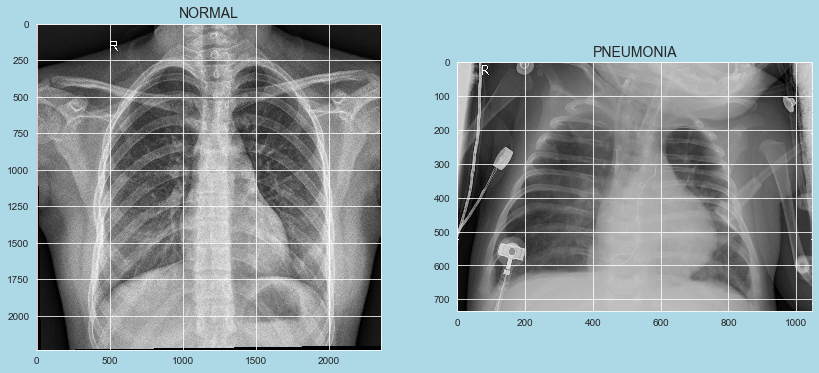

In [40]:
print('Train Subset')
print('------------')
X_ray_QC(train_dir, train_normal, train_pneumo)

Test Subset
------------
Normal xray file name: NORMAL2-IM-0272-0001.jpeg
Pneumo xray file name: person78_bacteria_382.jpeg


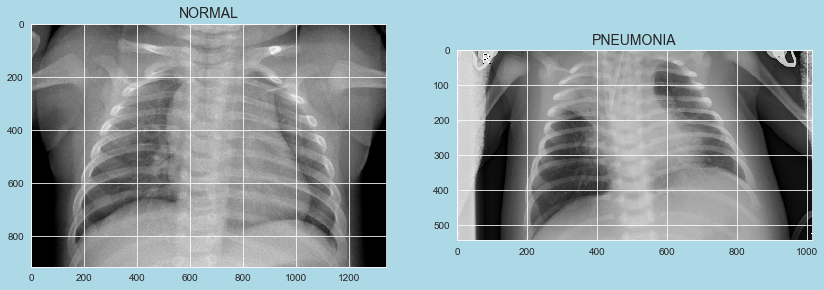

In [41]:
print('Test Subset')
print('------------')
X_ray_QC(test_dir, test_normal, test_pneumo)

Validate Subset
------------
Normal xray file name: NORMAL2-IM-1440-0001.jpeg
Pneumo xray file name: person1675_virus_2891.jpeg


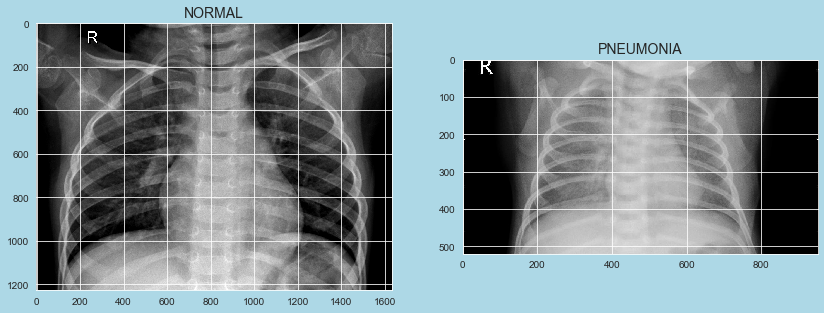

In [42]:
print('Validate Subset')
print('------------')
X_ray_QC(val_dir, val_normal, val_pneumo)

## Data (X-ray) QC

Since the X-rays are basically images classified/labeled into three groups (train, test and val), it is necessary to verify their balance. This will be done by looking at plots of the NORMAL and PNEUMONIA cases. 

In order to be able to plot them I can either count each one of the cases individually using the len() function, or I can create dataframes for each one of the different subsets (train, test, and val). 

Let's go with the dataframe option and create a function to do it automatically for the three subsets. This way I can create a binary column and use it to generate simple plots to look at their balance.

In [43]:
# FOR TRAIN SUBSET

train_df = []

normal_cases_dir = os.path.join(train_dir,'NORMAL')
pneumonia_cases_dir = os.path.join(train_dir,'PNEUMONIA')

# Get the list of all the images
normal_cases = glob(normal_cases_dir+"/*.jpeg")
pneumonia_cases = glob(pneumonia_cases_dir + "/*.jpeg")

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_df.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_df.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_df = pd.DataFrame(train_df, columns=['image', 'diagnosis'],index=None)

In [44]:
# FOR TEST SUBSET

test_df = []

normal_cases_dir = os.path.join(test_dir,'NORMAL')
pneumonia_cases_dir = os.path.join(test_dir,'PNEUMONIA')

# Get the list of all the images
normal_cases = glob(normal_cases_dir+"/*.jpeg")
pneumonia_cases = glob(pneumonia_cases_dir + "/*.jpeg")

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    test_df.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    test_df.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
test_df = pd.DataFrame(test_df, columns=['image', 'diagnosis'],index=None)

In [45]:
# FOR VAL SUBSET

val_df = []

normal_cases_dir = os.path.join(val_dir,'NORMAL')
pneumonia_cases_dir = os.path.join(val_dir,'PNEUMONIA')

# Get the list of all the images
normal_cases = glob(normal_cases_dir+"/*.jpeg")
pneumonia_cases = glob(pneumonia_cases_dir + "/*.jpeg")

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    val_df.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    val_df.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
val_df = pd.DataFrame(val_df, columns=['image', 'diagnosis'],index=None)

Dataframes have been successfully created for each of the subsets(train, test, and val), so let's take a look at their first and last 2 rows plus their shapes, which will hopefully match with the number of X-rays per subset:

In [46]:
display(train_df.head(2).append(train_df.tail(2)))
print('train_df shape:', train_df.shape)
print('==================================================')

display(test_df.head(2).append(test_df.tail(2)))
print('test_df shape:', test_df.shape)
print('==================================================')

display(val_df.head(2).append(val_df.tail(2)))
print('val_df shape:', val_df.shape)
print('==================================================')

,image,diagnosis
0,../chest_xray/train/NORMAL/NORMAL2-IM-0927-000...,0
1,../chest_xray/train/NORMAL/NORMAL2-IM-1056-000...,0
5214,../chest_xray/train/PNEUMONIA/person772_virus_...,1
5215,../chest_xray/train/PNEUMONIA/person501_virus_...,1


train_df shape: (5216, 2)


,image,diagnosis
0,../chest_xray/test/NORMAL/IM-0031-0001.jpeg,0
1,../chest_xray/test/NORMAL/IM-0025-0001.jpeg,0
522,../chest_xray/test/PNEUMONIA/person83_bacteria...,1
523,../chest_xray/test/PNEUMONIA/person112_bacteri...,1


test_df shape: (524, 2)


,image,diagnosis
0,../chest_xray/val/NORMAL/NORMAL2-IM-1440-0001....,0
1,../chest_xray/val/NORMAL/NORMAL2-IM-1437-0001....,0
114,../chest_xray/val/PNEUMONIA/person1627_virus_2...,1
115,../chest_xray/val/PNEUMONIA/person1661_virus_2...,1


val_df shape: (116, 2)


## Binary Data Plotting 

With the previous dataframes created for each of the subsets (train, test, and val), I will now create another function that will output the value_counts() of the 'diagnosis' column and then will plot each of these two values/diagnosis (0 and 1) in separate columns. This will now allow me to address if any of these subsets is not 'balanced

In [47]:
def scaling_check(data):
    
    case_count = data['diagnosis'].value_counts() # 'data' is our input which will be any of the 3 dataframes created
    print('Legend:')
    print(case_count)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x=case_count.index, y=case_count.values)
    plt.title('Diagnosis Balance Plot', fontsize=16)
    plt.xlabel('Diagnosis', fontsize=12)
    plt.ylabel('Number of Cases', fontsize=12)
    plt.xticks(range(len(case_count.index)), ['NORMAL(0)', 'PNEUMONIA(1)'])
    plt.show()

<b>Train Subset - Balance Review</b>

Legend:
1    3875
0    1341
Name: diagnosis, dtype: int64


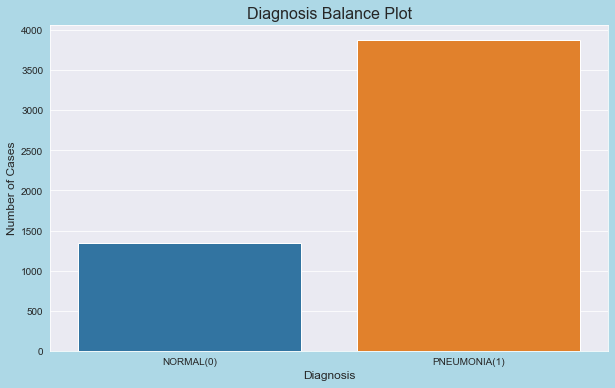

In [48]:
scaling_check(train_df)

<b>Test Subset - Balance Review</b>

Legend:
1    340
0    184
Name: diagnosis, dtype: int64


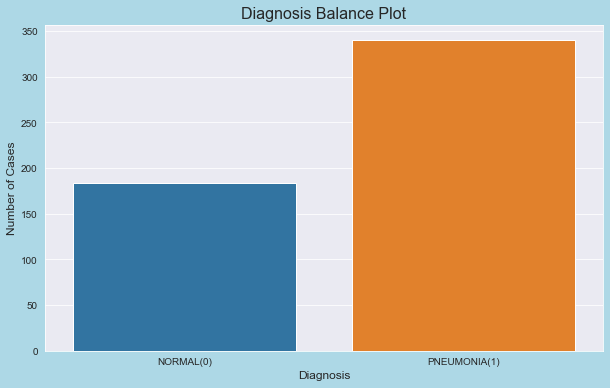

In [49]:
scaling_check(test_df)

There is no need to visualize the val_set, as it was manipulated directly due to initially having only 16 samples. 50 xrays images were added to each of the "NORMAL" and "PNEUMONIA" directories from the test directories. 

## Image Scaling and Augmentation

In [50]:
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

In [51]:
rescale = 1./255
target_size = (150,150)
batch_size = 32
class_mode = "categorical"
#class_mode = 'binary'

train_datagen = ImageDataGenerator(rescale=rescale, 
                                  shear_range=0.2, 
                                  zoom_range=0.2, 
                                  horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size, 
                                                    class_mode=class_mode,
                                                    batch_size=batch_size, 
                                                    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                       target_size=target_size,
                                                       class_mode=class_mode,
                                                       batch_size=dir_file_count(val_dir),
                                                       shuffle=False)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

Found 5216 images belonging to 2 classes.
Found 116 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [52]:
def data_processing(img_dims, batch_size):
    

    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(data_dir + 'test' + cond)):
                img = plt.imread(data_dir +'test'+cond+img)
                img = cv2.resize(img, (img_dims, img_dims))
                img = np.dstack([img, img, img])
                img = img.astype('float32') / 255
                if cond=='/NORMAL/':
                    label = 0
                elif cond=='/PNEUMONIA/':
                    label = 1
                test_data.append(img)
                test_labels.append(label)
        
        test_data = np.array(test_data)
        test_labels = np.array(test_labels)
    
    return (train_gen, test_gen, test_data, test_labels)

## Visualization Function Definition

The following function was created prior to starting with the modeling with the objective of being able to just call it and visualize the model(s) performance.

The function consists of a subplots made out of 2, 1 for the loss results and a second for the accuracy 

In [244]:
def model_perf_vis(history):
    
    history_dict = history.history
    train_loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    train_accuracy = history_dict['acc']
    val_accuracy = history_dict['val_acc']

    fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(7,7))
    
    # Loss plot 
    
    epochs = range(1, len(val_loss_values) + 1)
    chart1 = sns.lineplot(ax=axis[0], x=epochs, y=train_loss_values, label='Training Loss')
    
    chart1 = sns.lineplot(ax=axis[0], x=epochs, y=val_loss_values, label='Validation Loss')
    chart1.set(xlabel='Epochs', ylabel='Loss')
    chart1.axes.set_title('Model Loss', fontsize=20)
    chart1.grid(b=True, which='major', axis='y')
    
    chart2 = sns.lineplot(ax=axis[1], x=epochs, y=train_accuracy, label='Training Accuracy')
    chart2 = sns.lineplot(ax=axis[1], x=epochs, y=val_accuracy, label='Validation Accuracy')
    chart2.set(xlabel='Epochs', ylabel='Accuracy')
    chart2.axes.set_title('Model Accuracy', fontsize=20)
    chart2.grid(b=True, which='major', axis='y')
    
    plt.tight_layout()
    plt.show()

## CNN Models

from here onwards, Three different models will be tested with the main characteristics:

* <b>Model 1:</b> 
    
    * Four Conv2D layers (activation='relu')
    
    * Two Dense fully connected layers (activation='relu' (64), followed by 'softmax) (2))
    
    * Optimizer = Adam

* <b>Model 2:</b>

    * Three Conv2D layers (activation='relu')
    
    * Two Dense fully connected layers (activation='relu' (64), followed by 'softmax' (2))
    
    * Optimizer = Adam

* <b>Model 3:</b>

    * Three Conv2D layers (activation='relu')
    
    * Two Dense fully connected layers (activation='relu' (64), followed by 'softmax' (2))
    
    * Optimizer = Adam

As you will see later on, the three of them have been fit with 15 epochs for a preliminary evaluation, and further a series of parameters will be added/modified, before ultimately choosing a final model.

* Dropouts
* Augmentation
* Batch Normalization
* Regularizations


# Model 1

In [114]:
model_1 = models.Sequential()

# 1st Convolution
model_1.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolution
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolution
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

# 4th Convolution
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

# Flattened the layer
model_1.add(layers.Flatten())

# Fully connected layers
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(2, activation='softmax'))

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [115]:
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 20
steps_per_epoch=100
validation_steps=50

model_1.compile(optimizer, loss=loss, metrics=metrics)

history_M1 = model_1.fit_generator(train_generator, 
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  verbose=2,
                                  validation_data=validation_generator,
                                  validation_steps=validation_steps)

Epoch 1/20
 - 160s - loss: 0.4426 - acc: 0.8050 - val_loss: 0.3624 - val_acc: 0.8707
Epoch 2/20
 - 144s - loss: 0.2709 - acc: 0.8903 - val_loss: 0.2943 - val_acc: 0.8621
Epoch 3/20
 - 148s - loss: 0.2417 - acc: 0.9056 - val_loss: 0.3220 - val_acc: 0.8621
Epoch 4/20
 - 151s - loss: 0.2280 - acc: 0.9081 - val_loss: 0.2385 - val_acc: 0.9052
Epoch 5/20
 - 236s - loss: 0.2003 - acc: 0.9206 - val_loss: 0.4929 - val_acc: 0.7931
Epoch 6/20
 - 146s - loss: 0.1741 - acc: 0.9353 - val_loss: 0.5185 - val_acc: 0.8017
Epoch 7/20
 - 151s - loss: 0.1983 - acc: 0.9181 - val_loss: 0.3107 - val_acc: 0.8966
Epoch 8/20
 - 150s - loss: 0.1625 - acc: 0.9359 - val_loss: 0.3363 - val_acc: 0.8534
Epoch 9/20
 - 153s - loss: 0.1612 - acc: 0.9391 - val_loss: 0.1903 - val_acc: 0.9224
Epoch 10/20
 - 2323s - loss: 0.1615 - acc: 0.9400 - val_loss: 0.2504 - val_acc: 0.9138
Epoch 11/20
 - 328s - loss: 0.1523 - acc: 0.9425 - val_loss: 0.3108 - val_acc: 0.9052
Epoch 12/20
 - 333s - loss: 0.1466 - acc: 0.9437 - val_loss: 0

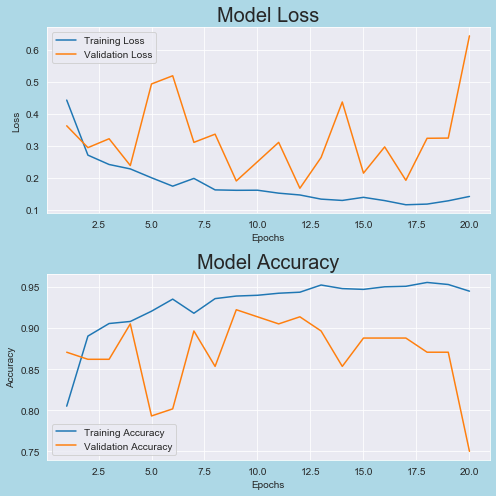

In [116]:
model_perf_vis(history_M1)

In [117]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

test_loss, test_acc = model_1.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)
print('test loss:' , test_loss)

Found 524 images belonging to 2 classes.
test accuracy: 0.8416030406951904
test loss: 0.5002813339233398


<b>OBSERVATIONS</b>

* There is clearly not convergence yet which is probably due to a short run of only 20 epochs. Maybe by increasing the epochs to 50 or more the validation set will converge and stabilize itself mode. 

* The train accuracy and loss curves are behaving quite well, as expected, with increasing epochs they get closer. 

* From a short run of 20 epochs the Train Accuracy ended at 94.66% and the Validatation Accuracy at 87.93%

## Evaluating Model_1 with test set:

In [67]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

test_loss, test_acc = model_1.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc*100, "%")
print('test loss:' , test_loss)

Found 524 images belonging to 2 classes.
test accuracy: 87.21374273300171 %
test loss: 0.4885842204093933


In [118]:
model_1.save('M1_Chest_xray_with_augmentation_data.h5')

# Model 2

Model 2 is the same as Model_1 but with an added padding ('same') and regularization ('l2').

In [42]:
model_2 = models.Sequential()

# 1st Convolution
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                         kernel_initializer='he_normal', 
                         kernel_regularizer='l2',
                         input_shape=(150, 150, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolution
model_2.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                         kernel_initializer='he_normal', 
                         kernel_regularizer='l2'))
model_2.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolution
model_2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                         kernel_initializer='he_normal', 
                         kernel_regularizer='l2'))
model_2.add(layers.MaxPooling2D((2, 2)))

# 4th Convolution
model_2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                         kernel_initializer='he_normal',
                         kernel_regularizer='l2'))
model_2.add(layers.MaxPooling2D((2, 2)))

# Flattened the layer
model_2.add(layers.Flatten())

# Fully connected layers
model_2.add(layers.Dense(64, activation='relu',
                        kernel_initializer='he_normal', 
                        kernel_regularizer='l2'))
model_2.add(layers.Dense(2, activation='softmax'))

model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 18, 18, 128)       147584    
__________

In [44]:
#model_2.compile(optimizer, loss=loss, metrics=metrics)

#history_M2 = model_2.fit_generator(train_generator, 
#                                  steps_per_epoch=steps_per_epoch,
#                                  epochs=epochs,
#                                  verbose=2,
#                                  validation_data=validation_generator,
#                                  validation_steps=validation_steps)

<b>OBSERVATIONS:</b>

* Validation Accuracy stayed stagnated at 50% for the first 5 epochs, so I stopped this model as those results imply the same accuracy as tossing a coin.

# Model_3

Model_3 is quite different and a bit more complex. I took this idea from looking at different notebooks from Kaggle.

In [45]:
model_3 = models.Sequential()

# 1st Convolution
model_3.add(layers.Conv2D(16, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model_3.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolution
model_3.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_3.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolution
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

# 4th Convolution
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

# Flattened the layer
model_3.add(layers.Flatten())

# Fully connected layers
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dense(2, activation='softmax'))

model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 146, 146, 16)      2320      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 71, 71, 32)        4640      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 69, 69, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 64)        18496     
__________

In [49]:
#model_3.compile(optimizer, loss=loss, metrics=metrics)
#
#history_M3 = model_3.fit_generator(train_generator, 
#                                  steps_per_epoch=steps_per_epoch,
#                                  epochs=epochs,
#                                  verbose=2,
#                                  validation_data=validation_generator,
#                                  validation_steps=validation_steps)

# Model 4

In [47]:
model_4 = models.Sequential()

# 1st Convolution
model_4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model_4.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolution
model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolution
model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

# 4th Convolution
model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

# Flattened the layer
model_4.add(layers.Flatten())

# Fully connected layers
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dense(2, activation='softmax'))

model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [48]:
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 30
steps_per_epoch=100
validation_steps=50

model_4.compile(optimizer, loss=loss, metrics=metrics)

history_M4 = model_4.fit_generator(train_generator, 
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  verbose=2,
                                  validation_data=validation_generator,
                                  validation_steps=validation_steps)

Epoch 1/30
 - 151s - loss: 0.4987 - acc: 0.7781 - val_loss: 0.4617 - val_acc: 0.7672
Epoch 2/30
 - 143s - loss: 0.2408 - acc: 0.9019 - val_loss: 0.3408 - val_acc: 0.8362
Epoch 3/30
 - 145s - loss: 0.2389 - acc: 0.9053 - val_loss: 0.2991 - val_acc: 0.8966
Epoch 4/30
 - 148s - loss: 0.1852 - acc: 0.9234 - val_loss: 0.3702 - val_acc: 0.8448
Epoch 5/30
 - 159s - loss: 0.2119 - acc: 0.9203 - val_loss: 0.4268 - val_acc: 0.8621
Epoch 6/30
 - 166s - loss: 0.1847 - acc: 0.9291 - val_loss: 0.5738 - val_acc: 0.7845
Epoch 7/30
 - 156s - loss: 0.1673 - acc: 0.9394 - val_loss: 0.2371 - val_acc: 0.9138
Epoch 8/30
 - 151s - loss: 0.1464 - acc: 0.9463 - val_loss: 0.2727 - val_acc: 0.8966
Epoch 9/30
 - 154s - loss: 0.1689 - acc: 0.9359 - val_loss: 0.2207 - val_acc: 0.8879
Epoch 10/30
 - 153s - loss: 0.1608 - acc: 0.9419 - val_loss: 0.1413 - val_acc: 0.9655
Epoch 11/30
 - 157s - loss: 0.1645 - acc: 0.9350 - val_loss: 0.3098 - val_acc: 0.8534
Epoch 12/30
 - 150s - loss: 0.1449 - acc: 0.9428 - val_loss: 0.

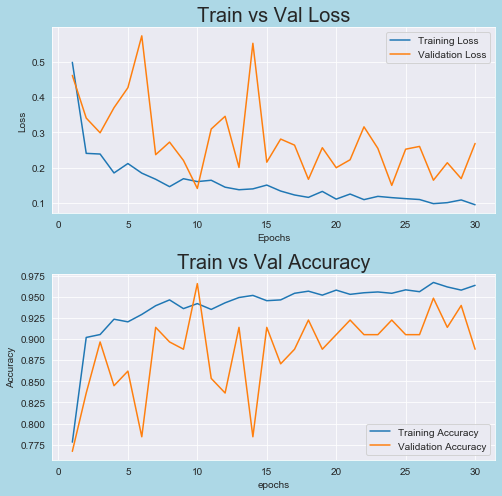

In [53]:
model_perf_vis(history_M4)

## Evaluating Model_4 with test set:

In [54]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

test_loss, test_acc = model_4.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)
print('test loss:' , test_loss)

Found 524 images belonging to 2 classes.
test accuracy: 0.9236640930175781
test loss: 0.3763611912727356


# Model 5

In [26]:
model_5 = models.Sequential()

# 1st Convolution
model_5.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model_5.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolution
model_5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolution
model_5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))

# 4th Convolution
model_5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))

# Flattened the layer
model_5.add(layers.Flatten())

# Fully connected layers
model_5.add(layers.Dense(64, activation='relu'))
model_5.add(layers.Dense(2, activation='softmax'))

model_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [27]:
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 50
steps_per_epoch=100
validation_steps=50

model_5.compile(optimizer, loss=loss, metrics=metrics)

history_M5 = model_5.fit_generator(train_generator, 
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  verbose=2,
                                  validation_data=validation_generator,
                                  validation_steps=validation_steps)

Epoch 1/50
 - 166s - loss: 0.4758 - acc: 0.7847 - val_loss: 0.8369 - val_acc: 0.5948
Epoch 2/50
 - 159s - loss: 0.2661 - acc: 0.8831 - val_loss: 0.2897 - val_acc: 0.8793
Epoch 3/50
 - 159s - loss: 0.2369 - acc: 0.9009 - val_loss: 0.3658 - val_acc: 0.8621
Epoch 4/50
 - 151s - loss: 0.2101 - acc: 0.9197 - val_loss: 0.9980 - val_acc: 0.6983
Epoch 5/50
 - 154s - loss: 0.1994 - acc: 0.9219 - val_loss: 0.3369 - val_acc: 0.9138
Epoch 6/50
 - 163s - loss: 0.1780 - acc: 0.9350 - val_loss: 0.5880 - val_acc: 0.7414
Epoch 7/50
 - 161s - loss: 0.1482 - acc: 0.9450 - val_loss: 0.3467 - val_acc: 0.8879
Epoch 8/50
 - 158s - loss: 0.1537 - acc: 0.9344 - val_loss: 0.2390 - val_acc: 0.9138
Epoch 9/50
 - 158s - loss: 0.1486 - acc: 0.9425 - val_loss: 0.1549 - val_acc: 0.9483
Epoch 10/50
 - 157s - loss: 0.1731 - acc: 0.9344 - val_loss: 0.2359 - val_acc: 0.9052
Epoch 11/50
 - 153s - loss: 0.1462 - acc: 0.9475 - val_loss: 0.1886 - val_acc: 0.9224
Epoch 12/50
 - 144s - loss: 0.1465 - acc: 0.9416 - val_loss: 0.

## Evaluating Model_5 with test set:

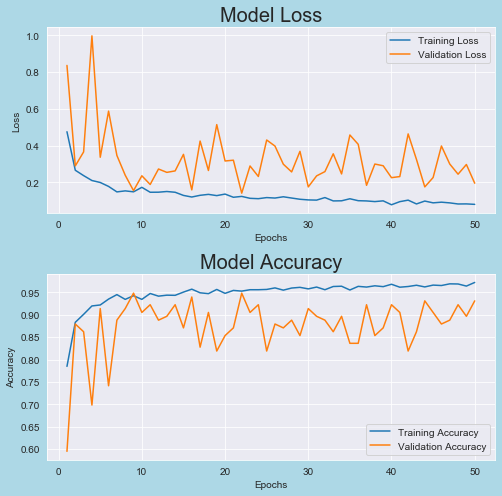

In [90]:
model_perf_vis(history_M5)

In [55]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

test_loss, test_acc = model_5.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)
print('test loss:' , test_loss)

Found 524 images belonging to 2 classes.
test accuracy: 0.9122137427330017
test loss: 0.39409029483795166


In [106]:
model_5.save('M5_Chest_xray_with_augmentation_data.h5')

# Model 6

In [56]:
model_6 = models.Sequential()

# 1st Convolution
model_6.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model_6.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolution
model_6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolution
model_6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))

# 4th Convolution
model_6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))

# Flattened the layer
model_6.add(layers.Flatten())

# Fully connected layers
model_6.add(layers.Dense(64, activation='relu'))
model_6.add(layers.Dense(2, activation='softmax'))

model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [57]:
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 100
steps_per_epoch=100
validation_steps=50

model_6.compile(optimizer, loss=loss, metrics=metrics)

history_M6 = model_6.fit_generator(train_generator, 
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  verbose=2,
                                  validation_data=validation_generator,
                                  validation_steps=validation_steps)

Epoch 1/100
 - 154s - loss: 0.5423 - acc: 0.7553 - val_loss: 0.6919 - val_acc: 0.7414
Epoch 2/100
 - 151s - loss: 0.3262 - acc: 0.8669 - val_loss: 0.3463 - val_acc: 0.8103
Epoch 3/100
 - 161s - loss: 0.2436 - acc: 0.9041 - val_loss: 0.5609 - val_acc: 0.7845
Epoch 4/100
 - 169s - loss: 0.2165 - acc: 0.9150 - val_loss: 0.4956 - val_acc: 0.8190
Epoch 5/100
 - 157s - loss: 0.2039 - acc: 0.9191 - val_loss: 0.5755 - val_acc: 0.7845
Epoch 6/100
 - 143s - loss: 0.1730 - acc: 0.9322 - val_loss: 0.2957 - val_acc: 0.8966
Epoch 7/100
 - 139s - loss: 0.1915 - acc: 0.9262 - val_loss: 0.2950 - val_acc: 0.8879
Epoch 8/100
 - 140s - loss: 0.1591 - acc: 0.9397 - val_loss: 0.3358 - val_acc: 0.8707
Epoch 9/100
 - 141s - loss: 0.1687 - acc: 0.9353 - val_loss: 0.3987 - val_acc: 0.8793
Epoch 10/100
 - 2439s - loss: 0.1569 - acc: 0.9431 - val_loss: 0.1727 - val_acc: 0.9310
Epoch 11/100
 - 340s - loss: 0.1704 - acc: 0.9350 - val_loss: 0.3030 - val_acc: 0.8966
Epoch 12/100
 - 342s - loss: 0.1360 - acc: 0.9494 -

Epoch 96/100
 - 150s - loss: 0.0577 - acc: 0.9772 - val_loss: 0.1290 - val_acc: 0.9569
Epoch 97/100
 - 562s - loss: 0.0504 - acc: 0.9813 - val_loss: 0.1715 - val_acc: 0.9224
Epoch 98/100
 - 154s - loss: 0.0569 - acc: 0.9766 - val_loss: 0.2387 - val_acc: 0.9138
Epoch 99/100
 - 149s - loss: 0.0601 - acc: 0.9781 - val_loss: 0.3911 - val_acc: 0.8621
Epoch 100/100
 - 147s - loss: 0.0392 - acc: 0.9856 - val_loss: 0.3582 - val_acc: 0.8707


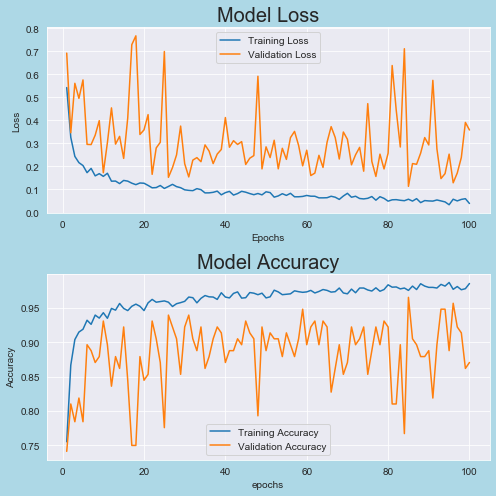

In [58]:
model_perf_vis(history_M6)

In [59]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

test_loss, test_acc = model_6.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)
print('test loss:' , test_loss)

Found 524 images belonging to 2 classes.
test accuracy: 0.9236640930175781
test loss: 0.3920062184333801


In [107]:
model_6.save('M6_Chest_xray_with_augmentation_data.h5')

# Model 7

In [61]:
model_7 = models.Sequential()

# 1st Convolution
model_7.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model_7.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolution
model_7.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_7.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolution
model_7.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_7.add(layers.MaxPooling2D((2, 2)))

# 4th Convolution
model_7.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_7.add(layers.MaxPooling2D((2, 2)))

# Flattened the layer
model_7.add(layers.Flatten())

# Fully connected layers
model_7.add(layers.Dense(64, activation='relu'))
model_7.add(layers.Dense(2, activation='softmax'))

model_7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 256)       295168    
__________

In [62]:
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 10
steps_per_epoch=100
validation_steps=50

model_7.compile(optimizer, loss=loss, metrics=metrics)

history_M7 = model_7.fit_generator(train_generator, 
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  verbose=2,
                                  validation_data=validation_generator,
                                  validation_steps=validation_steps)

Epoch 1/10
 - 167s - loss: 0.4651 - acc: 0.7963 - val_loss: 0.8715 - val_acc: 0.6983
Epoch 2/10
 - 156s - loss: 0.2733 - acc: 0.8828 - val_loss: 0.3023 - val_acc: 0.8707
Epoch 3/10
 - 155s - loss: 0.2237 - acc: 0.9094 - val_loss: 0.3295 - val_acc: 0.8707
Epoch 4/10
 - 157s - loss: 0.2253 - acc: 0.9156 - val_loss: 0.4652 - val_acc: 0.7931
Epoch 5/10
 - 160s - loss: 0.1883 - acc: 0.9247 - val_loss: 0.4984 - val_acc: 0.7931
Epoch 6/10
 - 165s - loss: 0.1804 - acc: 0.9234 - val_loss: 0.2332 - val_acc: 0.9310
Epoch 7/10
 - 165s - loss: 0.1662 - acc: 0.9387 - val_loss: 0.3364 - val_acc: 0.8707
Epoch 8/10
 - 161s - loss: 0.1651 - acc: 0.9316 - val_loss: 0.5786 - val_acc: 0.8190
Epoch 9/10
 - 160s - loss: 0.1674 - acc: 0.9406 - val_loss: 0.2244 - val_acc: 0.8966
Epoch 10/10
 - 162s - loss: 0.1554 - acc: 0.9356 - val_loss: 0.2015 - val_acc: 0.9397


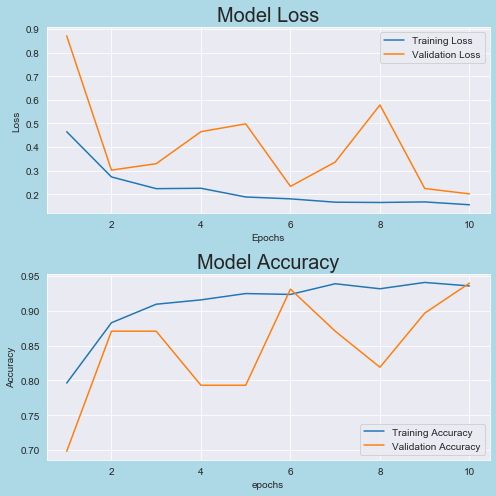

In [63]:
model_perf_vis(history_M7)

In [64]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

test_loss, test_acc = model_7.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)
print('test loss:' , test_loss)

Found 524 images belonging to 2 classes.
test accuracy: 0.9122137427330017
test loss: 0.2973337769508362


In [108]:
model_7.save('M7_Chest_xray_with_augmentation_data.h5')

# Model 8

In [66]:
model_8 = models.Sequential()

# 1st Convolution
model_8.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model_8.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolution
model_8.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolution
model_8.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))

# 4th Convolution
model_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))

# Flattened the layer
model_8.add(layers.Flatten())

# Fully connected layers
model_8.add(layers.Dense(64, activation='relu'))
model_8.add(layers.Dense(2, activation='softmax'))

model_8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 15, 15, 256)       295168    
__________

In [67]:
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 20
steps_per_epoch=100
validation_steps=50

model_8.compile(optimizer, loss=loss, metrics=metrics)

history_M8 = model_8.fit_generator(train_generator, 
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  verbose=2,
                                  validation_data=validation_generator,
                                  validation_steps=validation_steps)

Epoch 1/20
 - 153s - loss: 0.4898 - acc: 0.7837 - val_loss: 0.6228 - val_acc: 0.6983
Epoch 2/20
 - 154s - loss: 0.2626 - acc: 0.8931 - val_loss: 0.3566 - val_acc: 0.8362
Epoch 3/20
 - 163s - loss: 0.2085 - acc: 0.9109 - val_loss: 0.7346 - val_acc: 0.7931
Epoch 4/20
 - 155s - loss: 0.1984 - acc: 0.9194 - val_loss: 0.6697 - val_acc: 0.6983
Epoch 5/20
 - 150s - loss: 0.1831 - acc: 0.9313 - val_loss: 0.3056 - val_acc: 0.8534
Epoch 6/20
 - 154s - loss: 0.1418 - acc: 0.9437 - val_loss: 0.4340 - val_acc: 0.7845
Epoch 7/20
 - 151s - loss: 0.1828 - acc: 0.9309 - val_loss: 0.6743 - val_acc: 0.8017
Epoch 8/20
 - 163s - loss: 0.1635 - acc: 0.9344 - val_loss: 0.1793 - val_acc: 0.9052
Epoch 9/20
 - 158s - loss: 0.1599 - acc: 0.9378 - val_loss: 0.6856 - val_acc: 0.7586
Epoch 10/20
 - 159s - loss: 0.1318 - acc: 0.9509 - val_loss: 0.3795 - val_acc: 0.8534
Epoch 11/20
 - 153s - loss: 0.1329 - acc: 0.9503 - val_loss: 0.1629 - val_acc: 0.9397
Epoch 12/20
 - 153s - loss: 0.1453 - acc: 0.9422 - val_loss: 0.

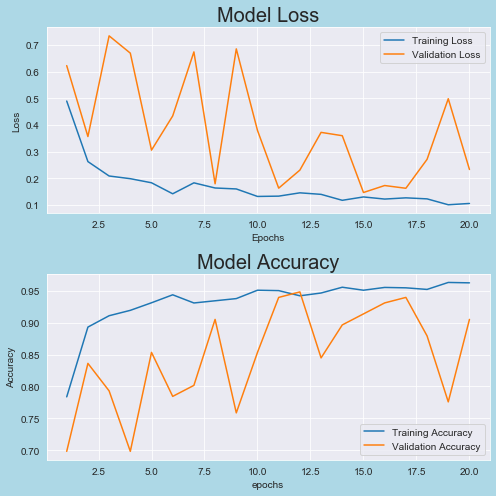

In [68]:
model_perf_vis(history_M8)

In [69]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

test_loss, test_acc = model_8.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)
print('test loss:' , test_loss)

Found 524 images belonging to 2 classes.
test accuracy: 0.9332060813903809
test loss: 0.3445863723754883


In [109]:
model_8.save('M8_Chest_xray_with_augmentation_data.h5')

# Model 9

In [77]:
model_9 = Sequential()

# 1st Convolution block
model_9.add(layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu',
                        input_shape=(150, 150, 3)))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

# 2nd Convolution block
model_9.add(layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model_9.add(layers.Dropout(0.1))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPooling2D((2, 2), strides=2, padding='same'))

# 3rd Convolution block
model_9.add(layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPooling2D((2, 2), strides=2, padding='same'))

# 4th Convolution block
model_9.add(layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model_9.add(layers.Dropout(0.2))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPooling2D((2, 2), strides=2, padding='same'))

# 5th Convolution block
model_9.add(layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
model_9.add(layers.Dropout(0.2))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPooling2D((2, 2), strides=2, padding='same'))

# Flattened the layer
model_9.add(layers.Flatten())

# Fully connected layers
model_9.add(layers.Dense(128, activation='relu'))
model_9.add(layers.Dropout(0.2))
model_9.add(layers.Dense(2, activation='softmax'))

model_9.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 38, 38, 64)        0         
__________

In [79]:
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 10
steps_per_epoch=100
validation_steps=50

model_9.compile(optimizer, loss=loss, metrics=metrics)

# Callbacks
#checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
#lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

# Model Fitting
history_M9 = model_9.fit_generator(train_generator, 
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  verbose=2,
                                  validation_data=validation_generator,
                                  validation_steps=validation_steps)



Epoch 1/10
 - 312s - loss: 0.4738 - acc: 0.8791 - val_loss: 0.5544 - val_acc: 0.7241
Epoch 2/10
 - 303s - loss: 0.1942 - acc: 0.9216 - val_loss: 0.9953 - val_acc: 0.6897
Epoch 3/10
 - 310s - loss: 0.1771 - acc: 0.9363 - val_loss: 0.2605 - val_acc: 0.8966
Epoch 4/10
 - 294s - loss: 0.1575 - acc: 0.9400 - val_loss: 0.5647 - val_acc: 0.6724
Epoch 5/10
 - 299s - loss: 0.1276 - acc: 0.9587 - val_loss: 0.3477 - val_acc: 0.8621
Epoch 6/10
 - 2016s - loss: 0.1394 - acc: 0.9494 - val_loss: 0.4865 - val_acc: 0.7155
Epoch 7/10
 - 294s - loss: 0.1258 - acc: 0.9584 - val_loss: 0.5723 - val_acc: 0.7328
Epoch 8/10
 - 295s - loss: 0.1165 - acc: 0.9591 - val_loss: 1.5477 - val_acc: 0.5259
Epoch 9/10
 - 291s - loss: 0.1320 - acc: 0.9519 - val_loss: 2.7844 - val_acc: 0.5000
Epoch 10/10
 - 304s - loss: 0.1148 - acc: 0.9562 - val_loss: 0.5209 - val_acc: 0.7759


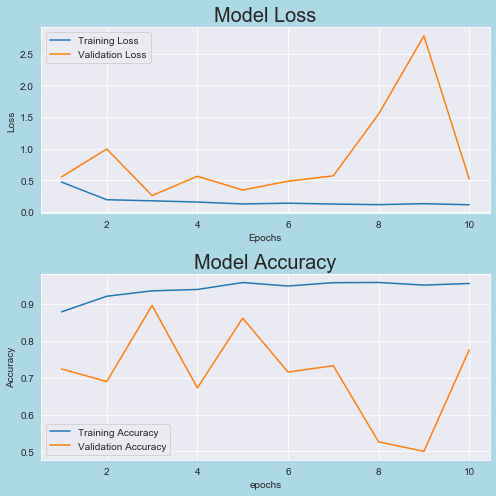

In [80]:
model_perf_vis(history_M9)

In [81]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

test_loss, test_acc = model_9.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)
print('test loss:' , test_loss)

Found 524 images belonging to 2 classes.
test accuracy: 0.7118320465087891
test loss: 0.5699529051780701


In [110]:
model_9.save('M9_Chest_xray_with_augmentation_data.h5')

# Model 10

In [91]:
model_10 = models.Sequential()

# 1st Convolution
model_10.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                        input_shape=(150, 150, 3)))
model_10.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolution
model_10.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_10.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolution
model_10.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model_10.add(layers.MaxPooling2D((2, 2)))

# 4th Convolution
model_10.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model_10.add(layers.MaxPooling2D((2, 2)))

# Flattened the layer
model_10.add(layers.Flatten())

# Fully connected layers
model_10.add(layers.Dense(64, activation='relu'))
model_10.add(layers.Dense(2, activation='softmax'))

model_10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 18, 18, 128)       147584    
__________

In [92]:
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 10
steps_per_epoch=100
validation_steps=50

model_10.compile(optimizer, loss=loss, metrics=metrics)

history_M10 = model_10.fit_generator(train_generator, 
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  verbose=2,
                                  validation_data=validation_generator,
                                  validation_steps=validation_steps)

Epoch 1/10
 - 156s - loss: 0.4230 - acc: 0.8156 - val_loss: 0.2448 - val_acc: 0.9138
Epoch 2/10
 - 158s - loss: 0.2543 - acc: 0.8972 - val_loss: 0.8295 - val_acc: 0.7155
Epoch 3/10
 - 153s - loss: 0.2145 - acc: 0.9169 - val_loss: 0.5165 - val_acc: 0.7845
Epoch 4/10
 - 165s - loss: 0.1886 - acc: 0.9269 - val_loss: 0.9909 - val_acc: 0.6207
Epoch 5/10
 - 158s - loss: 0.1718 - acc: 0.9366 - val_loss: 0.2953 - val_acc: 0.8793
Epoch 6/10
 - 159s - loss: 0.1685 - acc: 0.9387 - val_loss: 0.3540 - val_acc: 0.8362
Epoch 7/10
 - 157s - loss: 0.1781 - acc: 0.9294 - val_loss: 0.5968 - val_acc: 0.7931
Epoch 8/10
 - 159s - loss: 0.1470 - acc: 0.9419 - val_loss: 0.2634 - val_acc: 0.8966
Epoch 9/10
 - 162s - loss: 0.1340 - acc: 0.9463 - val_loss: 0.9386 - val_acc: 0.6638
Epoch 10/10
 - 161s - loss: 0.1285 - acc: 0.9478 - val_loss: 0.2749 - val_acc: 0.8966


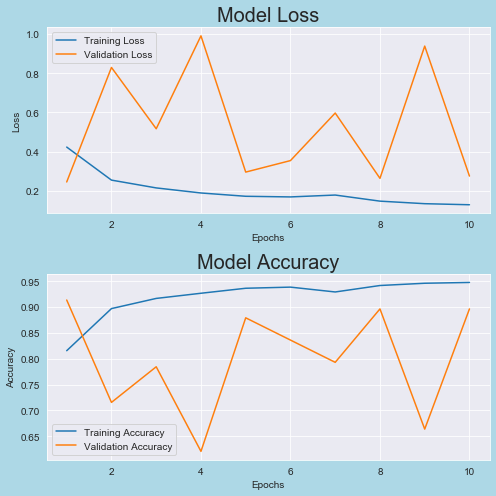

In [93]:
model_perf_vis(history_M10)

In [94]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

test_loss, test_acc = model_10.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)
print('test loss:' , test_loss)

Found 524 images belonging to 2 classes.
test accuracy: 0.8797709941864014
test loss: 0.5274299383163452


In [111]:
model_10.save('M10_Chest_xray_with_augmentation_data.h5')

# Model 11

In [96]:
model_11 = models.Sequential()

# 1st Convolution
model_11.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                           kernel_initializer='he_normal',
                           kernel_regularizer='l2', 
                           input_shape=(150, 150, 3)))
model_11.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolution
model_11.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', 
                           kernel_initializer='he_normal',
                           kernel_regularizer='l2'))
model_11.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolution
model_11.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', 
                           kernel_initializer='he_normal',
                           kernel_regularizer='l2'))
model_11.add(layers.MaxPooling2D((2, 2)))

# 4th Convolution
model_11.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', 
                           kernel_initializer='he_normal',
                           kernel_regularizer='l2'))
model_11.add(layers.MaxPooling2D((2, 2)))

# Flattened the layer
model_11.add(layers.Flatten())

# Fully connected layers
model_11.add(layers.Dense(64, activation='relu', 
                           kernel_initializer='he_normal',
                           kernel_regularizer='l2'))
model_11.add(layers.Dense(2, activation='softmax'))

model_11.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 18, 18, 128)       147584    
__________

In [97]:
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 10
steps_per_epoch=100
validation_steps=50

model_11.compile(optimizer, loss=loss, metrics=metrics)

history_M11 = model_11.fit_generator(train_generator, 
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  verbose=2,
                                  validation_data=validation_generator,
                                  validation_steps=validation_steps)

Epoch 1/10
 - 182s - loss: 7.6840 - acc: 0.7322 - val_loss: 9.3295 - val_acc: 0.5000
Epoch 2/10
 - 168s - loss: 2.0777 - acc: 0.7506 - val_loss: 1.2638 - val_acc: 0.5000
Epoch 3/10
 - 163s - loss: 0.9455 - acc: 0.7406 - val_loss: 1.0853 - val_acc: 0.5000
Epoch 4/10
 - 176s - loss: 0.7834 - acc: 0.7397 - val_loss: 0.9637 - val_acc: 0.5000
Epoch 5/10
 - 168s - loss: 0.6873 - acc: 0.7463 - val_loss: 0.9099 - val_acc: 0.5000
Epoch 6/10
 - 176s - loss: 0.6421 - acc: 0.7453 - val_loss: 0.8643 - val_acc: 0.5000
Epoch 7/10
 - 174s - loss: 0.6195 - acc: 0.7412 - val_loss: 0.8757 - val_acc: 0.5000
Epoch 8/10
 - 184s - loss: 0.5979 - acc: 0.7447 - val_loss: 0.8153 - val_acc: 0.5000
Epoch 9/10
 - 188s - loss: 0.5922 - acc: 0.7400 - val_loss: 0.8574 - val_acc: 0.5000
Epoch 10/10
 - 202s - loss: 0.5865 - acc: 0.7391 - val_loss: 0.8243 - val_acc: 0.5000


For some reason, when I apply regularization, the val_acc drops to 50% and stays completely stagnated. I have found no explanation for this so far.  

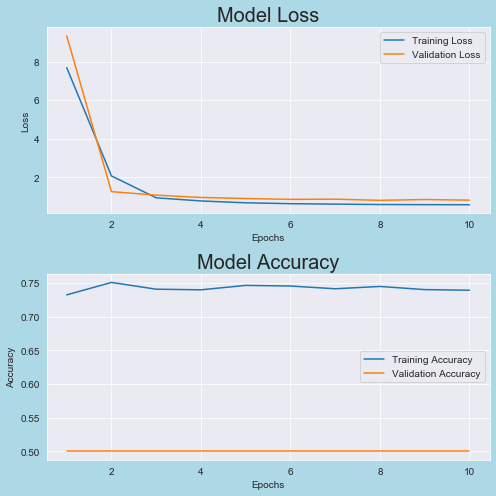

In [98]:
model_perf_vis(history_M11)

In [99]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

test_loss, test_acc = model_11.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)
print('test loss:' , test_loss)

Found 524 images belonging to 2 classes.
test accuracy: 0.6488549709320068
test loss: 0.6735820770263672


In [112]:
model_11.save('M11_Chest_xray_with_augmentation_data.h5')

# Model 12

<b>This i the same as Model_7 but fitted to 30 epochs instead of 10 to see if the model converges or not</b>

In [101]:
model_12 = models.Sequential()

# 1st Convolution
model_12.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model_12.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolution
model_12.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_12.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolution
model_12.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_12.add(layers.MaxPooling2D((2, 2)))

# 4th Convolution
model_12.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_12.add(layers.MaxPooling2D((2, 2)))

# Flattened the layer
model_12.add(layers.Flatten())

# Fully connected layers
model_12.add(layers.Dense(64, activation='relu'))
model_12.add(layers.Dense(2, activation='softmax'))

model_12.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 15, 15, 256)       295168    
__________

In [102]:
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 30
steps_per_epoch=100
validation_steps=50

model_12.compile(optimizer, loss=loss, metrics=metrics)

history_M12 = model_12.fit_generator(train_generator, 
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  verbose=2,
                                  validation_data=validation_generator,
                                  validation_steps=validation_steps)

Epoch 1/30
 - 215s - loss: 0.4412 - acc: 0.7975 - val_loss: 0.8650 - val_acc: 0.6293
Epoch 2/30
 - 198s - loss: 0.2755 - acc: 0.8831 - val_loss: 0.2481 - val_acc: 0.9138
Epoch 3/30
 - 236s - loss: 0.2165 - acc: 0.9188 - val_loss: 0.3528 - val_acc: 0.8362
Epoch 4/30
 - 223s - loss: 0.1762 - acc: 0.9359 - val_loss: 0.2308 - val_acc: 0.9138
Epoch 5/30
 - 210s - loss: 0.1785 - acc: 0.9287 - val_loss: 0.2701 - val_acc: 0.9138
Epoch 6/30
 - 165s - loss: 0.1613 - acc: 0.9372 - val_loss: 0.4284 - val_acc: 0.8707
Epoch 7/30
 - 155s - loss: 0.1614 - acc: 0.9394 - val_loss: 0.6859 - val_acc: 0.7069
Epoch 8/30
 - 161s - loss: 0.1551 - acc: 0.9372 - val_loss: 0.3775 - val_acc: 0.8362
Epoch 9/30
 - 162s - loss: 0.1688 - acc: 0.9375 - val_loss: 0.2417 - val_acc: 0.8966
Epoch 10/30
 - 166s - loss: 0.1441 - acc: 0.9481 - val_loss: 0.2324 - val_acc: 0.8966
Epoch 11/30
 - 168s - loss: 0.1352 - acc: 0.9469 - val_loss: 0.1743 - val_acc: 0.9138
Epoch 12/30
 - 165s - loss: 0.1546 - acc: 0.9416 - val_loss: 0.

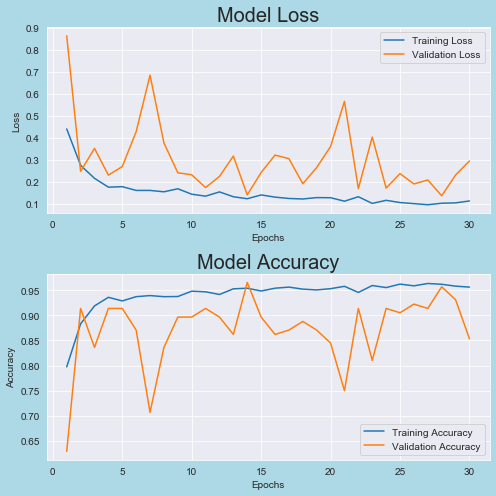

In [103]:
model_perf_vis(history_M12)

In [104]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

test_loss, test_acc = model_12.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)
print('test loss:' , test_loss)

Found 524 images belonging to 2 classes.
test accuracy: 0.8969465494155884
test loss: 0.3609415888786316


In [113]:
model_12.save('M12_Chest_xray_with_augmentation_data.h5')

# Model 13

In [119]:
model_13 = Sequential()

# 1st Convolution
model_13.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_13.add(Conv2D(32, (3, 3), activation='relu'))
model_13.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolution
model_13.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_13.add(Conv2D(32, (3, 3), activation='relu'))
model_13.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolution
model_13.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_13.add(Conv2D(32, (3, 3), activation='relu'))
model_13.add(layers.MaxPooling2D((2, 2)))

# 4th Convolution
model_13.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_13.add(Conv2D(32, (3, 3), activation='relu'))
model_13.add(layers.MaxPooling2D((2, 2)))

# Flattened the layer
model_13.add(layers.Flatten())

# Fully connected layers
model_13.add(layers.Dense(64, activation='relu'))
model_13.add(layers.Dense(2, activation='softmax'))

model_13.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 69, 69, 32)        18464     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 32, 32, 128)       36992     
__________

In [120]:
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 20
steps_per_epoch=100
validation_steps=50

model_13.compile(optimizer, loss=loss, metrics=metrics)

history_M13 = model_13.fit_generator(train_generator, 
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  verbose=2,
                                  validation_data=validation_generator,
                                  validation_steps=validation_steps)

Epoch 1/20
 - 258s - loss: 0.5400 - acc: 0.7534 - val_loss: 0.5062 - val_acc: 0.7328
Epoch 2/20
 - 251s - loss: 0.3791 - acc: 0.8222 - val_loss: 0.4780 - val_acc: 0.8017
Epoch 3/20
 - 260s - loss: 0.2939 - acc: 0.8738 - val_loss: 0.4125 - val_acc: 0.8448
Epoch 4/20
 - 228s - loss: 0.2719 - acc: 0.8903 - val_loss: 0.5966 - val_acc: 0.7414
Epoch 5/20
 - 3995s - loss: 0.2582 - acc: 0.8934 - val_loss: 0.3391 - val_acc: 0.8879
Epoch 6/20
 - 229s - loss: 0.2330 - acc: 0.9041 - val_loss: 0.3429 - val_acc: 0.8621
Epoch 7/20
 - 232s - loss: 0.2022 - acc: 0.9244 - val_loss: 0.2969 - val_acc: 0.8879
Epoch 8/20
 - 266s - loss: 0.2139 - acc: 0.9222 - val_loss: 0.3268 - val_acc: 0.8621
Epoch 9/20
 - 257s - loss: 0.1911 - acc: 0.9244 - val_loss: 0.3047 - val_acc: 0.9052
Epoch 10/20
 - 243s - loss: 0.1654 - acc: 0.9375 - val_loss: 0.2927 - val_acc: 0.8966
Epoch 11/20
 - 235s - loss: 0.1778 - acc: 0.9300 - val_loss: 0.4991 - val_acc: 0.7931
Epoch 12/20
 - 247s - loss: 0.1855 - acc: 0.9319 - val_loss: 0

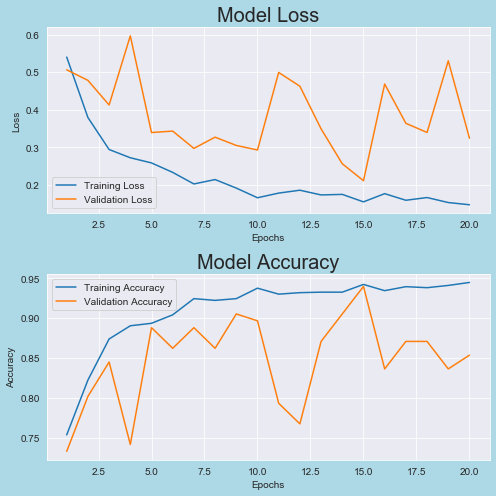

In [121]:
model_perf_vis(history_M13)

In [122]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

test_loss, test_acc = model_13.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)
print('test loss:' , test_loss)

Found 524 images belonging to 2 classes.
test accuracy: 0.8587786555290222
test loss: 0.31711721420288086


In [124]:
model_13.save('M13_Chest_xray_with_augmentation_data.h5')

# Model 14

In [133]:
model_14 = models.Sequential()

# 1st Convolution block
model_14.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
model_14.add(Conv2D(16, (3, 3), activation='relu'))
model_14.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolution block
model_14.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_14.add(Conv2D(32, (3, 3), activation='relu'))
model_14.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolution block
model_14.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_14.add(Conv2D(64, (3, 3), activation='relu'))
model_14.add(layers.MaxPooling2D((2, 2)))

# 4th Convolution block
model_14.add(layers.Conv2D(96, (3, 3), dilation_rate=(2,2), activation='relu', padding='same'))
model_14.add(Conv2D(96, (3, 3), activation='relu'))
model_14.add(layers.MaxPooling2D((2, 2)))

# 5th Convolution block
model_14.add(layers.Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same'))
model_14.add(Conv2D(128, (3, 3), activation='relu'))
model_14.add(layers.MaxPooling2D((2, 2)))

# Flattened the layer
model_14.add(layers.Flatten())

# Fully connected layers
model_14.add(layers.Dense(64, activation='relu'))
model_14.add(layers.Dropout(0.4))
model_14.add(layers.Dense(2, activation='softmax'))

model_14.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 148, 148, 16)      2320      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 74, 74, 32)        4640      
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 36, 36, 64)        18496     
__________

In [138]:
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 20
steps_per_epoch=100
validation_steps=50

model_14.compile(optimizer, loss=loss, metrics=metrics)

history_M14 = model_14.fit_generator(train_generator, 
                                      steps_per_epoch=steps_per_epoch, 
                                      epochs=epochs, 
                                      verbose=2, 
                                      validation_data=validation_generator, 
                                      validation_steps=validation_steps)

Epoch 1/20
 - 200s - loss: 0.5943 - acc: 0.7428 - val_loss: 0.8323 - val_acc: 0.5000
Epoch 2/20
 - 203s - loss: 0.5603 - acc: 0.7466 - val_loss: 0.6411 - val_acc: 0.7414
Epoch 3/20
 - 188s - loss: 0.4010 - acc: 0.8263 - val_loss: 0.6895 - val_acc: 0.6379
Epoch 4/20
 - 175s - loss: 0.3259 - acc: 0.8634 - val_loss: 0.6754 - val_acc: 0.7069
Epoch 5/20
 - 176s - loss: 0.2874 - acc: 0.8806 - val_loss: 0.4994 - val_acc: 0.8190
Epoch 6/20
 - 177s - loss: 0.2594 - acc: 0.8988 - val_loss: 0.3629 - val_acc: 0.8276
Epoch 7/20
 - 188s - loss: 0.2066 - acc: 0.9188 - val_loss: 0.5789 - val_acc: 0.8276
Epoch 8/20
 - 190s - loss: 0.1968 - acc: 0.9234 - val_loss: 0.5179 - val_acc: 0.7845
Epoch 9/20
 - 180s - loss: 0.1911 - acc: 0.9197 - val_loss: 0.3034 - val_acc: 0.8793
Epoch 10/20
 - 185s - loss: 0.1747 - acc: 0.9325 - val_loss: 0.3169 - val_acc: 0.8793
Epoch 11/20
 - 182s - loss: 0.1701 - acc: 0.9306 - val_loss: 0.2916 - val_acc: 0.9052
Epoch 12/20
 - 179s - loss: 0.1698 - acc: 0.9359 - val_loss: 0.

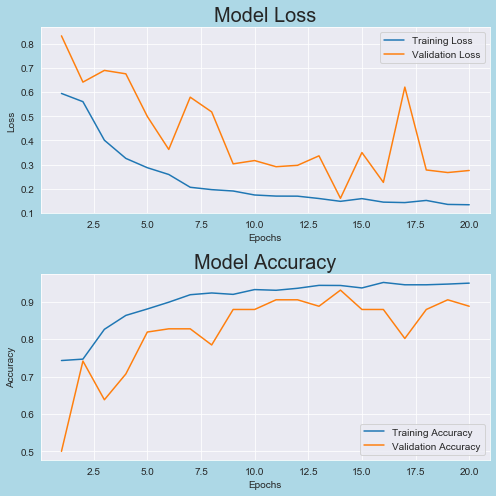

In [139]:
model_perf_vis(history_M14)

In [141]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

test_loss, test_acc = model_14.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)
print('test loss:' , test_loss)

Found 524 images belonging to 2 classes.
test accuracy: 0.8912213444709778
test loss: 0.317831426858902


In [140]:
model_14.save('M14_Chest_xray_with_augmentation_data.h5')

In [142]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(test_dir, 
                                                         target_size=(150, 150),
                                                         batch_size=32, 
                                                         shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_14.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 524 images belonging to 2 classes.


In [143]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())  

In [148]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

              precision    recall  f1-score   support

      NORMAL       0.82      0.67      0.74       184
   PNEUMONIA       0.84      0.92      0.88       340

    accuracy                           0.83       524
   macro avg       0.83      0.80      0.81       524
weighted avg       0.83      0.83      0.83       524



In [149]:
cm = confusion_matrix(true_classes, predicted_classes)
cm

array([[124,  60],
       [ 28, 312]])

In [150]:
cm = pd.DataFrame(cm, index = ['0', '1'], columns = ['0', '1'])

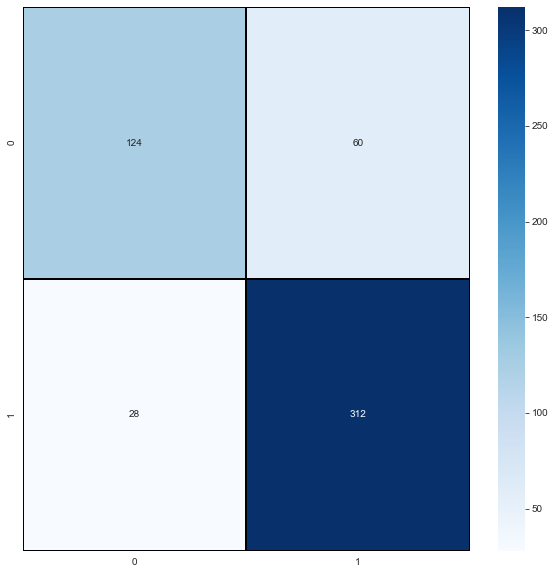

In [151]:
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [187]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)


# Model 15

In [157]:
model_15 = models.Sequential()

# 1st Convolution block
model_15.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', 
                           input_shape=(150, 150, 3)))
model_15.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_15.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolution block
model_15.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_15.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_15.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolution block
model_15.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_15.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_15.add(layers.MaxPooling2D((2, 2)))

# 4th Convolution block
model_15.add(layers.Conv2D(96, (3, 3), dilation_rate=(2,2), activation='relu', 
                           padding='same'))
model_15.add(layers.Conv2D(96, (3, 3), activation='relu'))
model_15.add(layers.MaxPooling2D((2, 2)))

# 5th Convolution block
model_15.add(layers.Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', 
                           padding='same'))
model_15.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_15.add(layers.MaxPooling2D((2, 2)))

# Flattened the layer
model_15.add(layers.Flatten())

# Fully connected layers
model_15.add(layers.Dense(64, activation='relu'))
model_15.add(layers.Dropout(0.4))
model_15.add(layers.Dense(2, activation='softmax'))

model_15.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 148, 148, 16)      2320      
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 74, 74, 32)        4640      
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 36, 36, 64)        18496     
__________

In [158]:
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 50
steps_per_epoch=100
validation_steps=50

model_15.compile(optimizer, loss=loss, metrics=metrics)

history_M15 = model_15.fit_generator(train_generator, 
                                      steps_per_epoch=steps_per_epoch, 
                                      epochs=epochs, 
                                      verbose=2, 
                                      validation_data=validation_generator, 
                                      validation_steps=validation_steps)

Epoch 1/50
 - 198s - loss: 0.5892 - acc: 0.7453 - val_loss: 0.8450 - val_acc: 0.5000
Epoch 2/50
 - 206s - loss: 0.5807 - acc: 0.7313 - val_loss: 0.7073 - val_acc: 0.5345
Epoch 3/50
 - 216s - loss: 0.4327 - acc: 0.8084 - val_loss: 0.5933 - val_acc: 0.7586
Epoch 4/50
 - 202s - loss: 0.3016 - acc: 0.8794 - val_loss: 0.6355 - val_acc: 0.7328
Epoch 5/50
 - 189s - loss: 0.2855 - acc: 0.8828 - val_loss: 0.5273 - val_acc: 0.7586
Epoch 6/50
 - 186s - loss: 0.2304 - acc: 0.9116 - val_loss: 0.4460 - val_acc: 0.7845
Epoch 7/50
 - 182s - loss: 0.2026 - acc: 0.9234 - val_loss: 0.5154 - val_acc: 0.7586
Epoch 8/50
 - 191s - loss: 0.1907 - acc: 0.9247 - val_loss: 0.3005 - val_acc: 0.8966
Epoch 9/50
 - 183s - loss: 0.1717 - acc: 0.9381 - val_loss: 0.3273 - val_acc: 0.8707
Epoch 10/50
 - 179s - loss: 0.1673 - acc: 0.9353 - val_loss: 0.2806 - val_acc: 0.8793
Epoch 11/50
 - 182s - loss: 0.1745 - acc: 0.9309 - val_loss: 0.2438 - val_acc: 0.8966
Epoch 12/50
 - 2105s - loss: 0.1741 - acc: 0.9328 - val_loss: 0

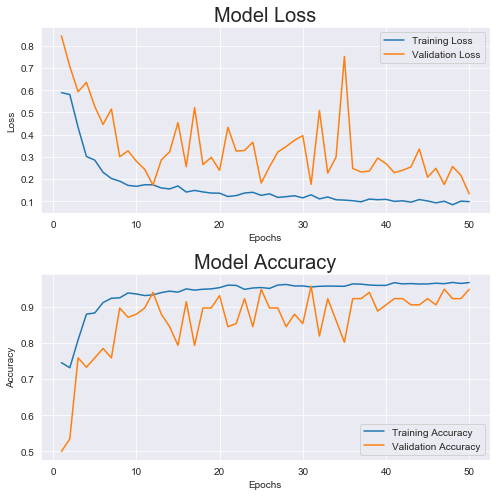

In [245]:
model_perf_vis(history_M15)

In [242]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=dir_file_count(test_dir),
                                                 shuffle=False)

test_loss, test_acc = model_15.evaluate_generator(test_generator, steps=50)
print('test accuracy:', round(test_acc*100, 2))
print('test loss:' , round(test_loss, 2))

Found 524 images belonging to 2 classes.
test accuracy: 90.84
test loss: 0.3


In [161]:
model_15.save('M15_Chest_xray_with_augmentation_data.h5')

In [163]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(test_dir, 
                                                         target_size=(150, 150),
                                                         batch_size=32, 
                                                         shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_15.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 524 images belonging to 2 classes.


In [164]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys()) 

In [254]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=['Normal (Class 0)','Pneumonia (Class 1)'])
print(report) 

                     precision    recall  f1-score   support

   Normal (Class 0)       0.73      0.77      0.75       184
Pneumonia (Class 1)       0.87      0.85      0.86       340

           accuracy                           0.82       524
          macro avg       0.80      0.81      0.81       524
       weighted avg       0.82      0.82      0.82       524



In [184]:
cm = confusion_matrix(true_classes, predicted_classes)
cm

array([[141,  43],
       [ 51, 289]])

In [268]:
cm = pd.DataFrame(cm, index = ['0', '1'], columns = ['0', '1'])

In [269]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)

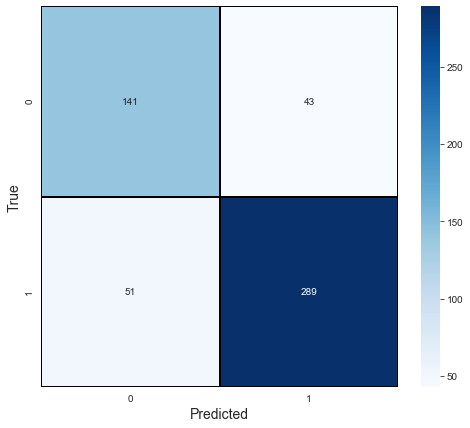

In [274]:
plt.figure(figsize = (8,7))
#labels = ['NORMAL', 'PNEUMONIA']
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1, annot = True, fmt='')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

In [241]:
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print('Precision score:', round(precision*100, 2))
print('Recall score:', round(recall*100, 2))
print('F1 score:', round(f1*100, 2))

Precision score: 87.05
Recall score: 85.0
F1 score: 86.01


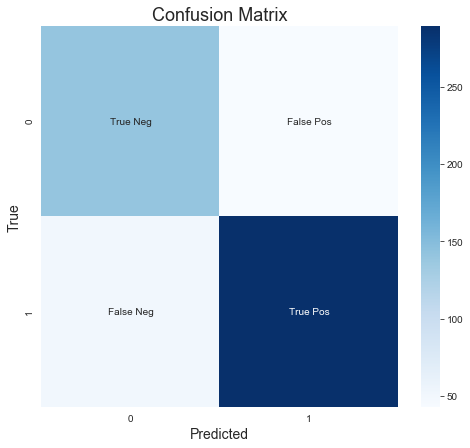

In [266]:
ax = plt.figure(figsize = (8,7))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()